In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
change_df = pd.read_csv('../datasets/group_people.csv')
bots_df = pd.read_csv('../datasets/bots.csv')
users_df = pd.read_csv('../datasets/users.csv')
data = pd.concat([bots_df, users_df, change_df])
data = data.fillna(0)


source_features = ['has_photo','has_mobile','is_friend','can_post','can_see_all_posts',
            'can_see_audio','can_write_private_message','can_send_friend_request',
            'can_be_invited_group','followers_count','blacklisted','blacklisted_by_me',
            'is_favorite','is_hidden_from_feed','common_count','university','faculty',
            'graduation','relation','verified','deactivated','friend_status','can_access_closed',
            'is_closed', 'city_id','country_id','last_seen_platform','last_seen_time',
            'interests_bool', 'books_bool', 'tv_bool', 'quotes_bool', 'about_bool',
            'games_bool', 'movies_bool', 'activities_bool', 'music_bool', 'mobile_phone_bool',
            'home_phone_bool', 'site_bool', 'status_bool', 'university_bool',
            'university_name_bool', 'faculty_bool', 'faculty_name_bool', 'graduation_bool',
            'home_town_bool', 'relation_bool', 'personal_bool', 'universities_bool',
            'schools_bool', 'occupation_bool', 'education_form_bool', 'education_status_bool',
            'relation_partner_bool', 'skype_bool', 'twitter_bool', 'livejournal_bool',
            'instagram_bool', 'facebook_bool', 'facebook_name_bool', 'relatives_in_friends_bool',
            'change_nickname_bool', 'partner_in_friends_bool', 'partner_in_friends_bool',
            'posts_count', 'users_subscriptions_count', 'groups_subscriptions_count',
            'albums_count', 'audios_count', 'gifts_count', 'pages_count', 'photos_count',
            'subscriptions_count', 'videos_count', 'video_playlists_count', 'subscriptions_followers_coef',
            'subscriptions_followers_coef_norm', 'friends_count']


In [64]:
class Result:
    def __init__(self, clf, accuracy, precision, recall, auc, f1, fpr, tpr):
        self.clf = clf
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.auc = auc
        self.f1 = f1
        self.fpr = fpr
        self.tpr = tpr
    
    @property
    def metrics_sum(self):
        return self.accuracy + self.precision + self.recall + self.auc + self.f1

# Feature selection

In [65]:
X, y = data[source_features], data[["bots"]].values.flatten()
clfs = [
    DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10),
    RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20),
    LogisticRegression(random_state=0, max_iter=1000, solver='saga'),
    svm.SVC(probability=True),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000),
    GaussianNB(),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    HistGradientBoostingClassifier()
]
results = []

for clf in clfs:    
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y)
    # Настройка функции t-SNE.
    embed = TSNE(
        n_components=3, # значение по умолчанию=2. Размерность вложенного пространства.
        perplexity=40, # значение по умолчанию=30.0. Перплексия связана с количеством ближайших соседей, которое используется в других алгоритмах обучения на множествах.
        early_exaggeration=12, # значение по умолчанию=12.0. Определяет, насколько плотными будут естественные кластеры исходного пространстве во вложенном пространстве и сколько места будет между ними. 
        learning_rate=300, # значение по умолчанию=200.0. Скорость обучения для t-SNE обычно находится в диапазоне [10.0, 1000.0]. Если скорость обучения слишком высока, данные могут выглядеть как "шар", в котором любая точка приблизительно равноудалена от ближайших соседей. Если скорость обучения слишком низкая, большинство точек могут быть похожими на сжатое плотное облако с незначительным количеством разбросов. 
        n_iter=500,
        n_iter_without_progress=300, # значение по умолчанию=300. Максимальное количество итераций без прогресса перед прекращением оптимизации, используется после 250 начальных итераций с ранним преувеличением.
        min_grad_norm=0.0000001, # значение по умолчанию=1e-7. Если норма градиента ниже этого порога, оптимизация будет остановлена.
        metric='euclidean', # значение по умолчанию='euclidean', Метрика, используемая при расчете расстояния между экземплярами в массиве признаков.
        init='pca', # {'random', 'pca'} или ndarray формы (n_samples, n_components), значение по умолчанию='random'. Инициализация вложения.
        verbose=0, # значение по умолчанию=0. Уровень детализации.
        random_state=None, # экземпляр RandomState или None, по умолчанию=None. Определяет генератор случайных чисел. Передача int для воспроизводимых результатов при многократном вызове функции.
        method='barnes_hut', # значение по умолчанию='barnes_hut'. По умолчанию алгоритм вычисления градиента использует аппроксимацию Барнса-Хата, работающую в течение времени O(NlogN). метод='exact' будет работать по более медленному, но точному алгоритму за время O(N^2). Следует использовать точный алгоритм, когда количество ошибок ближайших соседей должно быть ниже 3%.
        angle=0.5, # значение по умолчанию=0.5. Используется только если метод='barnes_hut' Это компромисс между скоростью и точностью в случае T-SNE с применением алгоритма Барнса-Хата.
        n_jobs=-1, # значение по умолчанию=None. Количество параллельных заданий для поиска соседей. -1 означает использование всех процессоров.
    )
    
    Xtrain = embed.fit_transform(Xtrain)
    Xtest = embed.fit_transform(Xtest)

    # Обучаем классификатор
    clf.fit(Xtrain, Ytrain)
    y_pred_test = clf.predict(Xtest)
    # Вычисляем метрики
    test_accuracy = accuracy_score(y_pred_test, Ytest)
    test_precision = precision_score(y_pred_test, Ytest)
    test_recall = recall_score(y_pred_test, Ytest)
    test_f1 = f1_score(y_pred_test, Ytest)

    y_pred_test = clf.predict(Xtest)
    y_true = Ytest
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_test)
    test_auc = auc(fpr, tpr)



    result = Result(clf, test_accuracy, test_precision, test_recall, test_auc, test_f1, fpr, tpr)
    results.append(result)

Kullback-Leibler divergence after optimization:  0.24689891934394836
No. of iterations:  499


# Plot graphs of metrics

/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_73383/1983010477.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_73383/1983010477.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_73383/1983010477.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_73383/1983010477.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_73383/1983010477.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes heig

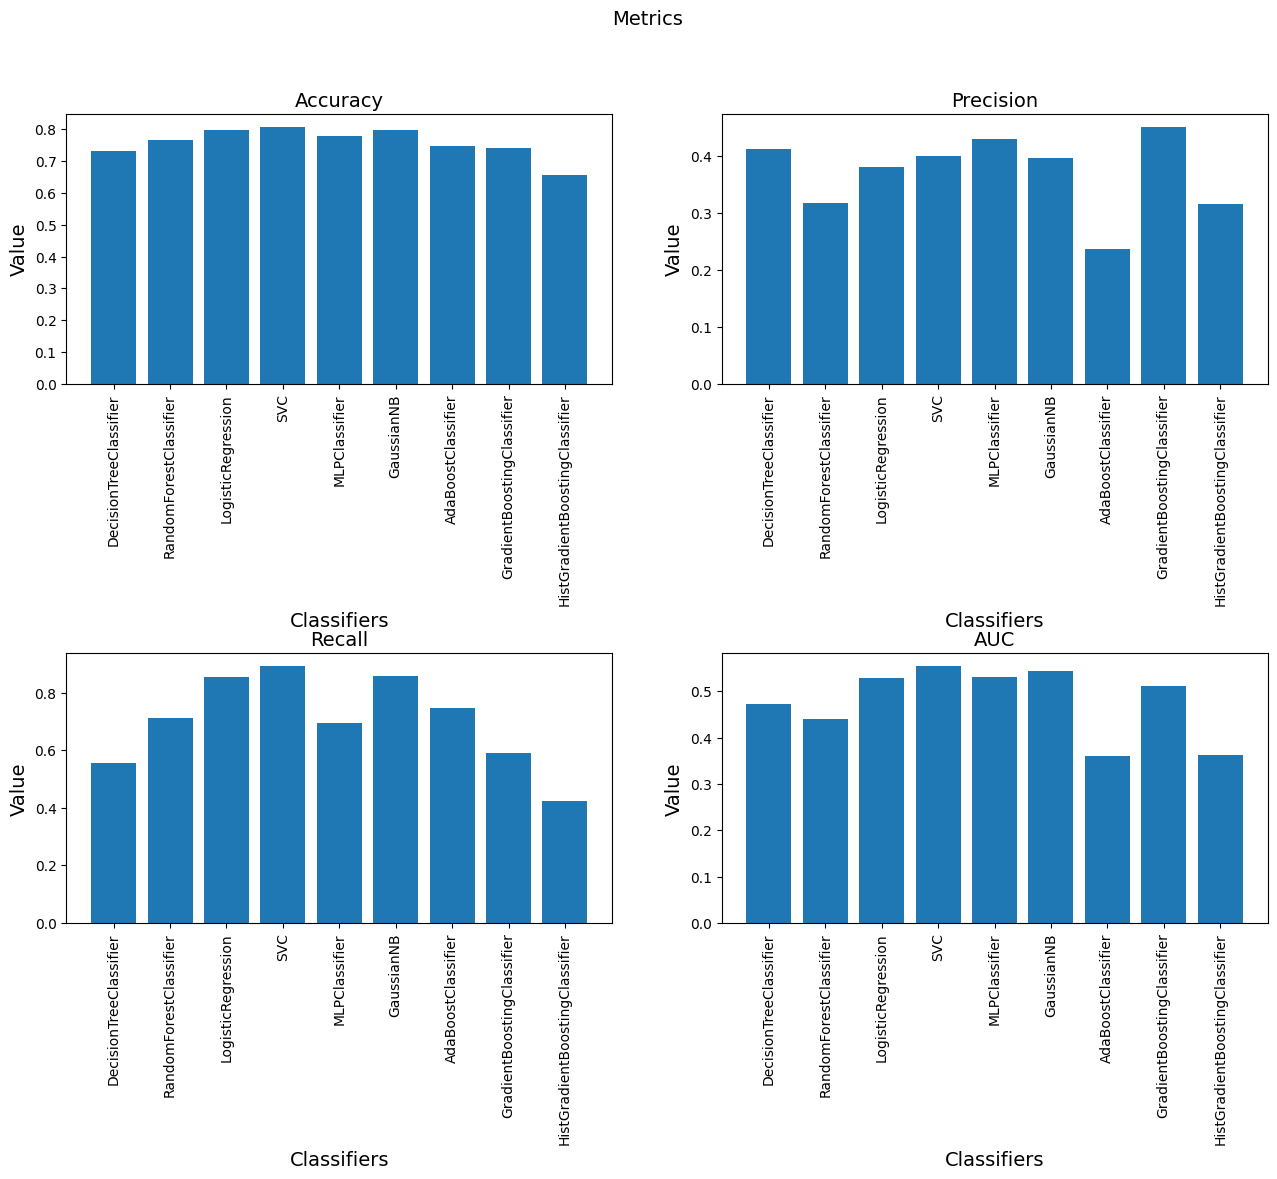

In [66]:
# Строим график столбцов
accuracy_values = [result.accuracy for result in results]
precision_values = [result.precision for result in results]
recall_values = [result.recall for result in results]
auc_values = [result.auc for result in results]
f1_values = [result.f1 for result in results]

# Добавляем заголовок и подписи осей
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=1)

clfs_names = [result.clf.__class__.__name__ for result in results]
# Первый график
axs[0, 0].bar(clfs_names, accuracy_values)
axs[0, 0].set_title('Accuracy', fontsize=14)
axs[0, 0].set_xlabel('Classifiers', fontsize=14)
axs[0, 0].set_ylabel('Value', fontsize=14)
axs[0, 0].set_xticklabels(clfs_names, rotation=90)

# Второй график
axs[0, 1].bar(clfs_names, precision_values)
axs[0, 1].set_title('Precision', fontsize=14)
axs[0, 1].set_xlabel('Classifiers', fontsize=14)
axs[0, 1].set_ylabel('Value', fontsize=14)
axs[0, 1].set_xticklabels(clfs_names, rotation=90)
# Третий график
axs[1, 0].bar(clfs_names, recall_values)
axs[1, 0].set_title('Recall', fontsize=14)
axs[1, 0].set_xlabel('Classifiers', fontsize=14)
axs[1, 0].set_ylabel('Value', fontsize=14)
axs[1, 0].set_xticklabels(clfs_names, rotation=90)
# Четвертый график
axs[1, 1].bar(clfs_names, f1_values)
axs[1, 1].set_title('AUC', fontsize=14)
axs[1, 1].set_xlabel('Classifiers', fontsize=14)
axs[1, 1].set_ylabel('Value', fontsize=14)
axs[1, 1].set_xticklabels(clfs_names, rotation=90)
# Настраиваем расположение графиков и добавляем общий заголовок
fig.tight_layout()
fig.suptitle('Metrics', fontsize=14)

# Сохраняем график
fig.set_size_inches(15.5, 10.5, forward=True)
fig.savefig('Metrics.png', dpi=300)
plt.show()

# Plot ROC curves

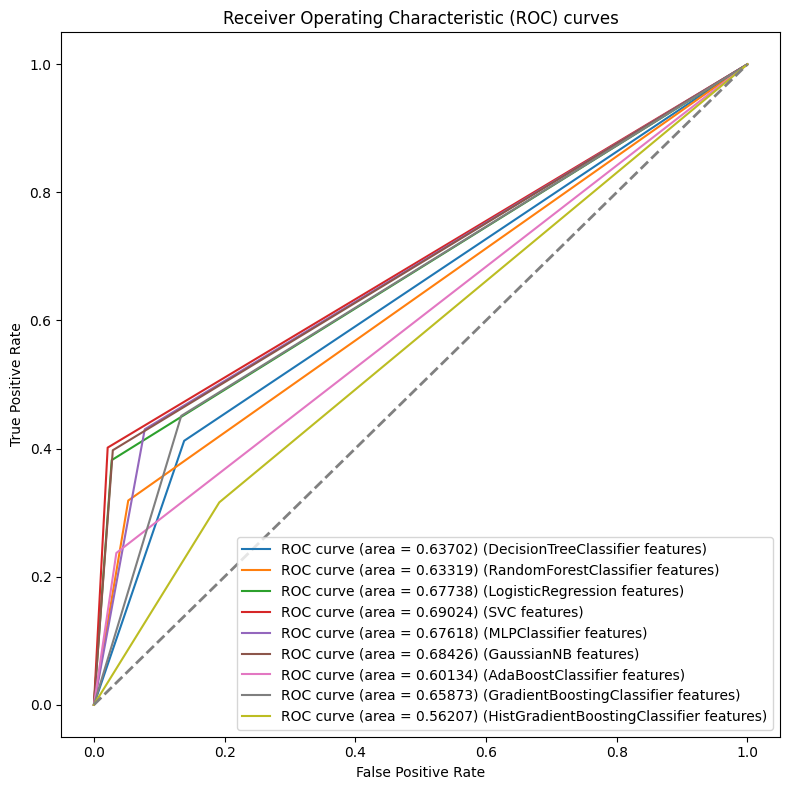

In [67]:
fig = plt.figure(figsize=(8, 8))

# Строим ROC кривые
for i in range(len(results)):
    plt.plot(
        results[i].fpr,
        results[i].tpr,
        label=f'ROC curve (area = %0.5f) ({results[i].clf.__class__.__name__} features)'% results[i].auc
    )

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")

# Сохраняем график
fig.tight_layout()
plt.savefig('ROC-curves.png', dpi=300)
plt.show()